# **SIREN** vs. **SIREN<sup>2</sup>**
This notebook provides the implementation details and compares the performance of SIREN and SIREN<sup>2</sup> presented at [hemanthgrylls.github.io](https://hemanthgrylls.github.io/). We reproduce some of the paper’s audio and image fitting experiments.

**Make sure to enable GPU:**
*   Go to Runtime (top right) → Change runtime type.
*   Set Hardware accelerator to T4 GPU (or other GPU). Click Save.
*   (If prompted) Restart the runtime.

In [43]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
import torch.nn as nn
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import numpy as np
import librosa
import soundfile as sf
from PIL import Image
import torchvision.transforms as T
import numpy.fft as fft
import torch.nn.functional as F

if torch.cuda.is_available():
    device = torch.device("cuda")       # NVIDIA GPUs
elif torch.backends.mps.is_available():
    device = torch.device("mps")        # Apple silicon
else:
    device = torch.device("cpu")        # in case you are pathetic

print(f"Using device: {device}")

Using device: cuda


# Helper functions for pre-processing and training (you can skip through this cell)

In [50]:

def spectral_centroid(x):
    # Last axis is always channels
    num_channels = x.shape[-1]
    centroids = []

    for c in range(num_channels):
        data_c = x[..., c]  # Extract channel c
        ndim = data_c.ndim

        if ndim == 1:  # Audio single signal
            spectrum = np.abs(np.fft.rfft(data_c))
            freq_bins = np.fft.rfftfreq(data_c.shape[-1], d=1)
            weighted_sum = np.sum(spectrum * freq_bins)
            sum_of_weights = np.sum(spectrum)
            centroid = weighted_sum / sum_of_weights if sum_of_weights != 0 else 0

        elif ndim == 2:  # Image (H, W)
            spectrum = np.abs(np.fft.rfft(data_c, axis=1))
            freq_bins = np.fft.rfftfreq(data_c.shape[1], d=1)
            weighted_sum = np.sum(spectrum * freq_bins, axis=1)
            sum_of_weights = np.sum(spectrum, axis=1)
            row_centroids = np.divide(weighted_sum, sum_of_weights, out=np.zeros_like(weighted_sum), where=sum_of_weights != 0)
            centroid = np.mean(row_centroids)

        elif ndim == 3:  # 3D data (H, W, D)
            spectrum = np.abs(np.fft.rfft(data_c, axis=2))
            freq_bins = np.fft.rfftfreq(data_c.shape[2], d=1)
            weighted_sum = np.sum(spectrum * freq_bins, axis=2)
            sum_of_weights = np.sum(spectrum, axis=2)
            slice_centroids = np.divide(weighted_sum, sum_of_weights, out=np.zeros_like(weighted_sum), where=sum_of_weights != 0)
            centroid = np.mean(slice_centroids)

        else:
            raise ValueError("Unsupported data dimensionality after removing channel axis.")

        centroids.append(centroid)

    # Average across channels and normalize to [0, 1]
    return (np.mean(centroids) * 2) / num_channels

#############################################  audio related  #############################################
def set_audio_target(device, file_path, max_samples):
    waveform, sr = wav_to_tensor(file_path)
    waveform /= torch.max(torch.abs(waveform))  # normalize to [-1, 1]
    waveform = waveform.to(device)
    n_samples = min(max_samples, waveform.shape[0])

    return waveform[:n_samples].view(-1,1), n_samples, sr


def wav_to_tensor(filepath, sr=None, mono=True):
    audio, sample_rate = librosa.load(filepath, sr=sr, mono=mono)
    tensor = torch.tensor(audio)
    return tensor, sample_rate


def tensor_to_wav(tensor, sample_rate, output_filepath='sample.wav'):
    audio = tensor.to('cpu').detach().numpy()
    sf.write(output_filepath, audio, sample_rate)

#############################################  network related  #############################################
@torch.jit.script
def sine_block(x: torch.Tensor, w0: float, a0: float):
    return a0 * torch.sin(w0 * x)

class SineLayer(nn.Module):
    def __init__(self, w0, A=1.0):
        super().__init__()
        self.a0 = A
        self.w0 = w0

    def forward(self,x):
        return sine_block(x, self.w0, self.a0)

#############################################  image related  #############################################
def compute_fft_image(img_tensor):
    # img_tensor shape: (C, H, W)
    # Compute FFT magnitude (only on first channel if multiple)
    img_np = img_tensor[0].cpu().numpy()
    fft_img = fft.fftshift(fft.fft2(img_np))
    magnitude = np.log1p(np.abs(fft_img))
    return magnitude

def generate_coordinates(H, W, device):
    x = torch.linspace(-1, 1, steps=H, device=device)
    y = torch.linspace(-1, 1, steps=W, device=device)
    grid_x, grid_y = torch.meshgrid(x, y, indexing='ij')
    return torch.cat((grid_x.reshape(-1,1), grid_y.reshape(-1,1)), dim=1)

def show_image(ax, img_tensor):
    img = img_tensor
    ax.axis('off')

    # Auto denormalize if data is in [-1, 1]
    if img.min() < 0:
        img = img * 0.5 + 0.5

    # Handle channel placement and dimensions
    if img.ndim == 2:
        img_np = img.detach().cpu().numpy()
        ax.imshow(img_np, cmap='gray')

    elif img.ndim == 3:
        if img.shape[0] == 1:  # (1, H, W) → grayscale
            img_np = img[0].detach().cpu().numpy()
            ax.imshow(img_np, cmap='gray')

        elif img.shape[0] == 3:  # (3, H, W) → RGB
            img_np = img.permute(1, 2, 0).detach().cpu().numpy()
            ax.imshow(img_np)

        elif img.shape[0] == 5:  # (5, H, W) → show channel 0 using inferno
            img_np = img[0].detach().cpu().numpy()
            ax.imshow(np.flipud(img_np), cmap='RdBu')

        elif img.shape[2] == 1:  # (H, W, 1) → grayscale
            img_np = img[:, :, 0].detach().cpu().numpy()
            ax.imshow(img_np, cmap='gray')

        elif img.shape[2] == 3:  # (H, W, 3) → RGB
            img_np = img.detach().cpu().numpy()
            ax.imshow(img_np)

        else:
            raise ValueError(f"Unsupported 3D tensor shape: {img.shape}")

    else:
        raise ValueError(f"Unsupported tensor shape: {img.shape}")


def save_reconstructed_image(tensor, path, n_channels):
    """
    Saves the reconstructed image tensor as a PNG file using PIL.

    Parameters:
    - tensor: torch.Tensor of shape (C, H, W), values in [-1, 1] or [0, 1].
    - path: full file path including .png extension.
    - n_channels: number of image channels (1 for grayscale, 3 for RGB).
    """
    tensor = tensor.detach().cpu()

    # Rescale from [-1, 1] to [0, 1] if necessary
    if tensor.min() < 0:
        tensor = (tensor + 1) / 2

    tensor = tensor.clamp(0, 1)

    if n_channels == 1:
        image_np = (tensor[0] * 255).numpy().astype('uint8')  # shape: (H, W)
        image = Image.fromarray(image_np, mode='L')
    elif n_channels == 3:
        image_np = (tensor.permute(1, 2, 0) * 255).numpy().astype('uint8')  # shape: (H, W, 3)
        image = Image.fromarray(image_np, mode='RGB')
    elif n_channels == 5:  # (5, H, W) → show channel 0 using inferno
        image_np = (tensor.permute(1, 2, 0) * 255).numpy().astype('uint8')  # shape: (H, W, 3)
        image = Image.fromarray(image_np[:,:,0], mode='L')
    else:
        raise ValueError(f"Unsupported number of channels: {n_channels}")

    os.makedirs(os.path.dirname(path), exist_ok=True)
    image.save(path)


def set_target(device, filepath, gray=False):
    ext = os.path.splitext(filepath)[-1].lower()    # get the extension

    ### for loading images
    image_exts = ['.png', '.jpg', '.jpeg', '.bmp', '.tiff']     # Supported image extensions


    if ext in image_exts:
        image = Image.open(filepath)
        if image.mode in ['P', 'RGBA']:
            image = image.convert('RGB')
        if gray:
            image = image.convert('L')
        if image.mode == 'L':  # grayscale
            transform = T.Compose([
                T.ToTensor(),           # shape (1, H, W)
                T.Normalize(0.5, 0.5)   # normalize to [-1, 1]
            ])
            img = transform(image).squeeze(0).to(device)  # shape (H, W)
            img = img.unsqueeze(0)                        # shape (1, H, W)
        elif image.mode == 'RGB':
            transform = T.Compose([
                T.ToTensor(),                              # shape (3, H, W)
                T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
            ])
            img = transform(image).to(device)             # shape (3, H, W)
        else:
            raise ValueError(f"Unsupported image mode: {image.mode}")

    n_channels = img.shape[0]
    H = img.shape[1]
    W = img.shape[2]
    print(f'n_channels: {n_channels}')
    print(f'img shape: {img.shape}')
    pixel_values = img.permute(1, 2, 0).view(-1, n_channels)

    return img, H, W, pixel_values, n_channels


#############################################  training related  #############################################
def batched_forward(model, coords, batch_size=65536):
    """
    Perform <<model(coords_batch)>> in smaller batches to avoid OOM.
    """
    outputs = []
    N = coords.shape[0]
    for i in range(0, N, batch_size):
        coords_batch = coords[i:i+batch_size]
        out = model(coords_batch)
        outputs.append(out.detach().cpu())
    return torch.cat(outputs, dim=0)


def train(model, coords, ground_truth, config, device, nb_epochs, batch_size):
    model.to(device)
    coords = coords.to(device)
    ground_truth = ground_truth.to(device)

    loss_fun = nn.MSELoss()
    model_optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
    scheduler = StepLR(model_optimizer, step_size=config.scheculer_step, gamma=config.gamma)

    psnr_history = []
    total_points = coords.shape[0]
    best_psnr = -float('inf')
    best_model_state = None

    pbar = tqdm(range(nb_epochs))
    for _ in pbar:
        indices = torch.randperm(total_points)
        epoch_loss = 0.0

        for i in range(0, total_points, batch_size):
            batch_indices = indices[i:i + batch_size]
            coords_batch = coords[batch_indices, :]
            gt_batch = ground_truth[batch_indices, :]

            output = model(coords_batch)
            loss = ((output - gt_batch) ** 2).mean()
            epoch_psnr = 20 * np.log10(1.0 / np.sqrt(loss.item()))

            model_optimizer.zero_grad()
            loss.backward()
            model_optimizer.step()

            epoch_loss += loss.item()

        # Full-batch PSNR estimate (optional but used in your original logic)
        epoch_psnr = 20 * np.log10(1.0 / np.sqrt(loss.item()))
        psnr_history.append(epoch_psnr)

        if epoch_psnr > best_psnr:
            best_psnr = epoch_psnr
            best_model_state = model.state_dict()

        pbar.set_postfix({'PSNR': f'{epoch_psnr:.2f} dB'})
        scheduler.step()

    # Restore best model and compute its output
    model.load_state_dict(best_model_state)
    output = batched_forward(model, coords, batch_size=65536)

    return psnr_history, output


Define **SIREN** and **SIREN_square** models

In [45]:
# define the models

# Original SIREN
class SIREN(nn.Module):
    def __init__(self, in_dim, HL_dim, out_dim, w0=30, first_w0=3000, n_HLs=4):
        super().__init__()
        self.net = []

        self.net.append(nn.Linear(in_dim, HL_dim))
        self.net.append(SineLayer(first_w0))
        for _ in range(n_HLs-1):
            self.net.append(nn.Linear(HL_dim, HL_dim))
            self.net.append(SineLayer(w0))
        self.net.append(nn.Linear(HL_dim, out_dim))

        self.net = nn.Sequential(*self.net)

        # init weights
        with torch.no_grad():
            self.net[0].weight.uniform_(-1.0/in_dim, 1.0/in_dim)
            for i in range(n_HLs):
                self.net[(i+1)*2].weight.uniform_(-np.sqrt(6.0/HL_dim)/w0, np.sqrt(6.0/HL_dim)/w0)

    def forward(self, x):
        return self.net(x)


class SIREN_square(nn.Module):
    def __init__(self, omega_0=30, in_dim=1, HL_dim=256, out_dim=1, first_omega=30, n_HLs=4, spectral_centeroid = 0, S0=0, S1=0):
        super().__init__()
        self.in_dim = in_dim
        self.omega_0 = omega_0
        self.S0 = S0    # noise scale between INPUT and 1st HIDDEN LAYER
        self.S1 = S1    # noise scale between 1st and 2nd HIDDEN LAYERS
        self.SC = spectral_centeroid
        self.n_ch = out_dim

        # define network architecture
        self.net = []
        self.net.append(nn.Linear(in_dim, HL_dim))
        self.net.append(SineLayer(first_omega))
        for _ in range(n_HLs-1):
            self.net.append(nn.Linear(HL_dim, HL_dim))
            self.net.append(SineLayer(omega_0))
        self.net.append(nn.Linear(HL_dim, out_dim))

        self.net = nn.Sequential(*self.net)

        # initialize weights
        with torch.no_grad():
            self.net[0].weight.uniform_(-1.0/in_dim, 1.0/in_dim)

            for i in range(n_HLs):
                self.net[(i+1)*2].weight.uniform_(-np.sqrt(6.0/HL_dim)/self.omega_0, np.sqrt(6.0/HL_dim)/self.omega_0)

            self.weights0 = self.net[0].weight.detach().clone()
            self.weights2 = self.net[2].weight.detach().clone()

        # add noise
        self.set_noise_scales()
        self.add_noise()

    def set_noise_scales(self):
        # insert the emperical formula to set S0 and S1 values as a function of (SC/n_ch)
        if self.in_dim == 1:    # audio
            a, b = 7, 3
            self.S0 = 3500*(1-np.exp(-a*self.SC/self.n_ch))
            self.S1 = self.SC/self.n_ch * b
        elif self.in_dim == 2:  # images
            a, b = 5, 0.4
            self.S0 = 50*(1-np.exp(-a*self.SC/self.n_ch))
            self.S1 = self.SC/self.n_ch * b
        elif self.in_dim == 3:  # 3D
            self.S0 = self.S0
            self.S1 = self.S1

        # or manually set the noise scales
        # self.S0 = self.S0
        # self.S1 = self.S1

        # print(f'spectral centeroid = {self.SC}, SIREN^2 set to noise scales S0={self.S0} and S1={self.S1}')

    def add_noise(self):
        with torch.no_grad():
            # INPUT LAYER --> FIRST HIDDEN LAYER (uniform + noise)
            scale = self.S0 / self.omega_0
            self.net[0].weight.copy_(self.weights0 + torch.randn_like(self.weights0) * scale)

            # FIRST --> SECOND HIDDEN LAYER (uniform + noise)
            scale = self.S1 / self.omega_0
            self.net[2].weight.copy_(self.weights2 + torch.randn_like(self.weights2) * scale)

            # Free memory after use
            del self.weights0, self.weights2
            torch.cuda.empty_cache()

    def forward(self, coords):
        return self.net(coords)


# Experiments

## 1. Fitting Audio Signals

Firstly, lets us set the define the network setup and define the target

In [46]:
import scipy.io.wavfile as wavfile
import io
from IPython.display import Audio, display

class config:
    lr = 1e-4               # learning rate
    gamma = 0.99            # learning rate decay factor
    scheculer_step = 20     # iteration frequency to update learning rate
    n_HLs = 4               # number of hidden layers
    nb_epochs = 500         # total training epochs
    HL_dim = 222            # hidden layer dimension
    max_samples = 150000
    n_channels = 1

def get_networks(config, n_channels, HL_dim=256, SC=0, S0=0, S1=0):
    return [
        SIREN(in_dim=1, HL_dim=HL_dim, out_dim=n_channels, first_w0=3000, w0=30, n_HLs=config.n_HLs).to(device),
        SIREN_square(omega_0=30, in_dim=1, HL_dim=HL_dim, out_dim=1, first_omega=30, n_HLs=config.n_HLs, spectral_centeroid = SC, S0=S0, S1=S1).to(device),
    ]

# download files
if not os.path.exists('tetris.wav'):
    # try main, fall back to master
    !wget -O tetris.wav https://raw.githubusercontent.com/hemanthgrylls/SIREN-square/main/training_data/audio/tetris.wav \
    || wget -O tetris.wav https://raw.githubusercontent.com/hemanthgrylls/SIREN-square/master/training_data/audio/tetris.wav

if not os.path.exists('relay.wav'):
    # try main, fall back to master
    !wget -O relay.wav https://raw.githubusercontent.com/hemanthgrylls/SIREN-square/main/training_data/audio/relay.wav \
    || wget -O relay.wav https://raw.githubusercontent.com/hemanthgrylls/SIREN-square/master/training_data/audio/relay.wav

# audio_files = ['relay.wav', 'tetris.wav']
audio_files = ['relay.wav']

# display the ground truth audio files
for i in range(len(audio_files)):
  print(f'Ground truth: {audio_files[i]}')
  waveform_gt, _, sample_rate = set_audio_target(device, audio_files[i], config.max_samples)
  display(Audio(waveform_gt.detach().cpu().squeeze().numpy(), rate=sample_rate))

Ground truth: relay.wav


Now, let's train **SIREN** and **SIREN_square** to fit the audio

In [47]:
for file in audio_files:
  print(f'\nProcessing: {file}')

  waveform_gt, n_samples, sample_rate = set_audio_target(device, file, config.max_samples)
  coords = torch.linspace(-1, 1, n_samples, device=device).view(-1,config.n_channels)

  SC = spectral_centroid(waveform_gt.detach().cpu().numpy())

  for i, model in enumerate(get_networks(config, n_channels=config.n_channels, HL_dim=config.HL_dim, SC=SC, S0=3000, S1=1)):
      model_name = f"{model.__class__.__name__}"
      print(f'Training {model_name}...')
      batch_size = min(n_samples,512*512)

      psnr, model_output = train(model, coords, waveform_gt, config, device, nb_epochs=config.nb_epochs, batch_size=batch_size)
      print(f'\n{model_name} reconstruction ({max(psnr)}:.1f): {file} \n \n')
      display(Audio(model_output.cpu().detach().squeeze().numpy(),rate=sample_rate))



Processing: relay.wav
Training SIREN...


100%|██████████| 500/500 [00:32<00:00, 15.27it/s, PSNR=20.05 dB]



SIREN reconstruction (20.04544077300315): relay.wav


Training SIREN_square...


100%|██████████| 500/500 [00:34<00:00, 14.70it/s, PSNR=40.10 dB]


SIREN_square reconstruction (40.09963627559729): relay.wav


# 2. Image fitting

First, let's setup the networks, targets, and define the training configuration


In [61]:
class config:
    lr = 1e-4               # learning rate
    gamma = 0.998           # learning rate decay factor
    scheculer_step = 20     # iteration frequency to update learning rate
    n_HLs = 4               # number of hidden layers
    nb_epochs = 1000        # total training epochs
    HL_dim = 256            # hidden layer dimension

def get_networks(config, n_channels, HL_dim=256, SC=0, S0=0, S1=0):
    return [
        SIREN(in_dim=2, HL_dim=HL_dim, out_dim=n_channels, first_w0=30, w0=30, n_HLs=config.n_HLs).to(device),
        SIREN_square(omega_0=30, in_dim=2, HL_dim=HL_dim, out_dim=1, first_omega=30, n_HLs=config.n_HLs, spectral_centeroid = SC, S0=S0, S1=S1).to(device),
    ]

if not os.path.exists('camera.png'):
    # try main, fall back to master
    !wget -O camera.png https://raw.githubusercontent.com/hemanthgrylls/SIREN-square/main/training_data/images/camera.png \
    || wget -O camera.png https://raw.githubusercontent.com/hemanthgrylls/SIREN-square/master/training_data/images/camera.png

if not os.path.exists('braided_0064_gray.jpg'):
    # try main, fall back to master
    !wget -O braided_0064_gray.jpg https://raw.githubusercontent.com/hemanthgrylls/SIREN-square/main/training_data/images/braided_0064_gray.jpg \
    || wget -O braided_0064_gray.jpg https://raw.githubusercontent.com/hemanthgrylls/SIREN-square/master/training_data/images/braided_0064_gray.jpg


# image_files = ['camera.png', 'braided_0064_gray.jpg']
image_files = ['braided_0064_gray.jpg']

Start training **SIREN** and **SIREN_square** to fit the image, and then plot the results in both physical and Fourier space


Processing: braided_0064_gray.jpg
n_channels: 1
img shape: torch.Size([1, 400, 400])
Training (SIREN)...


100%|██████████| 10000/10000 [12:43<00:00, 13.10it/s, PSNR=42.96 dB]


Training (SIREN_square)...


100%|██████████| 10000/10000 [12:45<00:00, 13.06it/s, PSNR=57.72 dB]


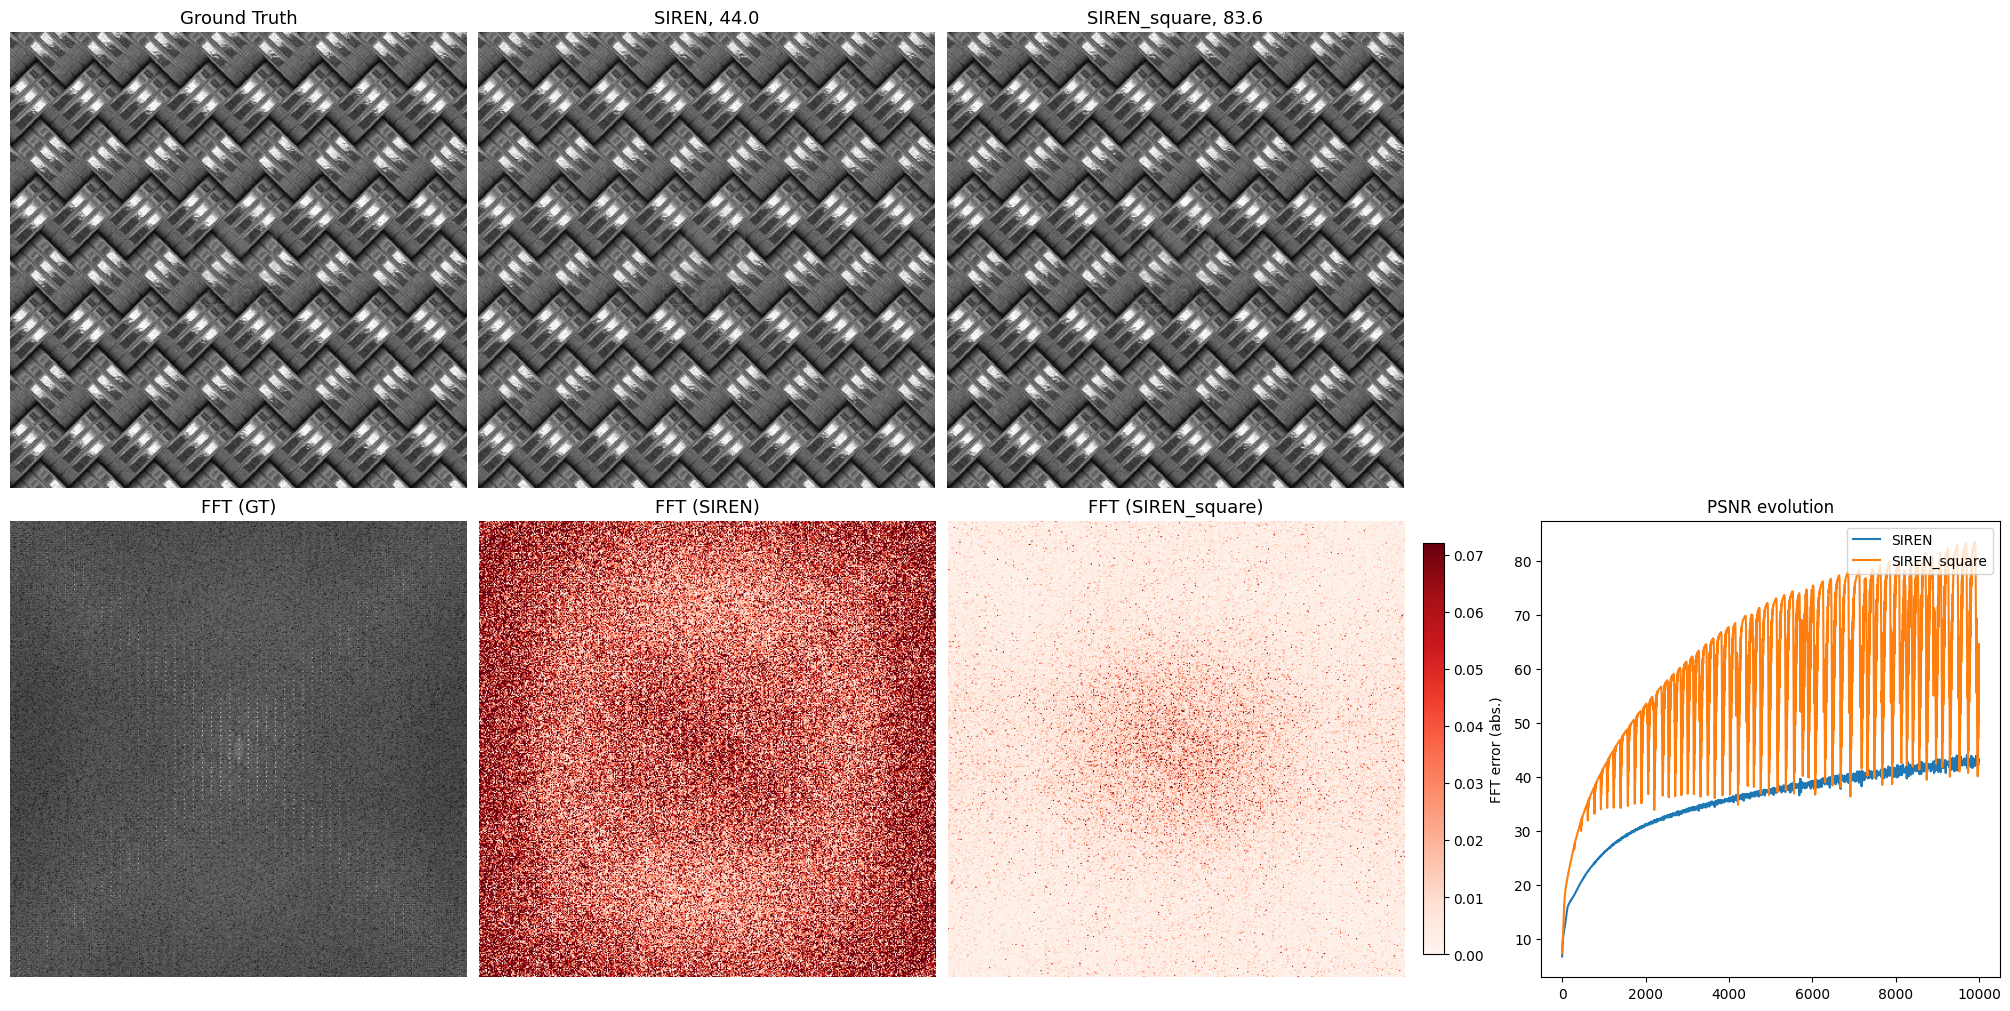

In [62]:
from matplotlib import colors

for img_file in image_files:
  print(f'\nProcessing: {img_file}')
  base_name = os.path.splitext(os.path.basename(img_file))[0]

  img, H, W, pixel_values, n_channels = set_target(device=device, filepath=img_file)
  coords = generate_coordinates(H, W, device)
  SC = spectral_centroid(pixel_values.detach().cpu().numpy())

  n_models = len(get_networks(config, n_channels, SC=SC, HL_dim=config.HL_dim))
  fig, axes = plt.subplots(2, n_models + 2, figsize=(5*(n_models+2), 10),
                           constrained_layout=True)  # ← use constrained layout
  # (remove fig.subplots_adjust and plt.tight_layout)

  show_image(axes[0][0], img)
  axes[0][0].set_title('Ground Truth', fontsize=13)

  fft_gt = compute_fft_image(img)
  axes[1][0].imshow(fft_gt, cmap='gray')
  axes[1][0].set_title('FFT (GT)', fontsize=13)
  axes[1][0].axis('off')

  fft_errs, model_outputs = [], []

  for i, model in enumerate(get_networks(config, n_channels, SC=SC, HL_dim=config.HL_dim)):
      model_name = f"{model.__class__.__name__}"
      print(f'Training ({model_name})...')
      batch_size = 256*256 if model_name in ['ReLU_PE','WIRE','GAUSS'] else 512*512
      psnr, model_output = train(model, coords, pixel_values, config, device,
                                 nb_epochs=config.nb_epochs, batch_size=batch_size)
      reconstructed = model_output.cpu().T.view(n_channels, H, W)
      model_outputs.append((model_name, reconstructed, psnr))
      fft_recon = compute_fft_image(reconstructed)
      fft_errs.append(np.abs(fft_recon - fft_gt))

  global_vmax = np.percentile(np.concatenate([e.ravel() for e in fft_errs]), 85)
  norm = colors.Normalize(vmin=0, vmax=global_vmax)

  im_axes = []  # collect axes used for the shared colorbar
  for i, (model_name, reconstructed, psnr) in enumerate(model_outputs):
      show_image(axes[0][i+1], reconstructed)
      axes[0][i+1].set_title(f'{model_name}, {max(psnr):.1f}', fontsize=13)

      fft_err = np.abs(compute_fft_image(reconstructed) - fft_gt)
      im = axes[1][i+1].imshow(fft_err, cmap='Reds', norm=norm)
      axes[1][i+1].set_title(f'FFT ({model_name})', fontsize=13)
      axes[1][i+1].axis('off')
      im_axes.append(axes[1][i+1])

      axes[1][-1].plot(psnr, label=f'{model_name}')

  # shared colorbar for all FFT-error images
  cbar = fig.colorbar(im, ax=im_axes, location='right', pad=0.02, shrink=0.9)
  cbar.set_label('FFT error (abs.)')

  axes[0][-1].axis('off')
  axes[1][-1].set_title('PSNR evolution')
  axes[1][-1].legend(loc='upper right')

  plt.show()
